# A-1 Data Processing and EDA

Training Data:
   Unnamed: 0   Loan_ID Gender Married Dependents Education Self_Employed  \
0           0  LP001518   Male     Yes          1  Graduate            No   
1           1  LP002734   Male     Yes          0  Graduate            No   
2           2  LP002697   Male      No          0  Graduate            No   
3           3  LP002455   Male     Yes          2  Graduate            No   
4           4  LP001732   Male     Yes          2  Graduate           NaN   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             1538             1425.0        30.0             360.0   
1             6133             3906.0       324.0             360.0   
2             4680             2087.0         NaN             360.0   
3             3859                0.0        96.0             360.0   
4             5000                0.0        72.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1  

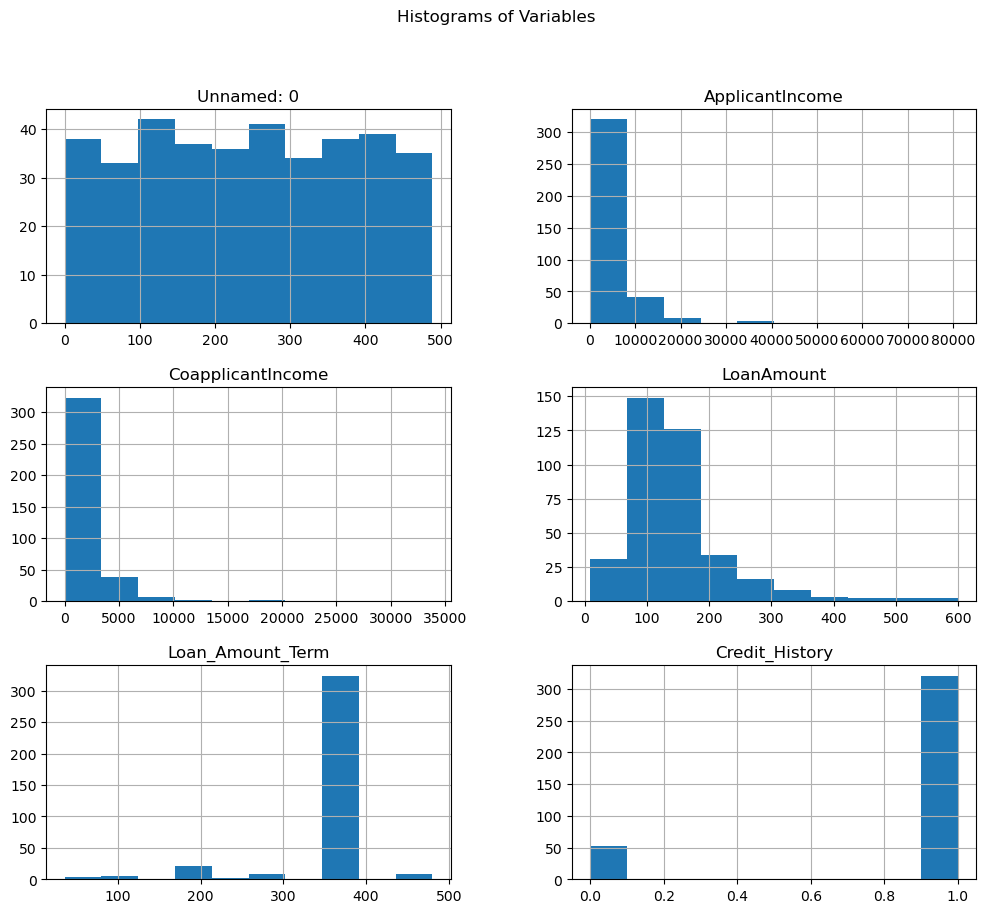

Categorical Features:
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area'],
      dtype='object')

Continuous Features:
Index(['Unnamed: 0', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')


In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Read the data
data_train = pd.read_csv('/Users/ritikanigam/Downloads/data_train-1.csv')
data_test = pd.read_csv('/Users/ritikanigam/Downloads/data_test-1.csv')

# Step 2: Print the training data
print("Training Data:")
print(data_train.head())

# Step 3: Return the shape of the data
print("Shape of Training Data:", data_train.shape)

# Step 4: Check for missing values and process the data
print("Missing Values in Training Data:")
print(data_train.isnull().sum())

# Remove rows with missing values
data_train = data_train.dropna()

# Step 5: Extract features and labels
features = data_train.drop('Loan_Status', axis=1)
labels = data_train['Loan_Status']

X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2, random_state=5)

features_test = data_test

# Step 6: Plot histograms of all variables
data_train.hist(figsize=(12, 10))
plt.suptitle("Histograms of Variables")
plt.show()

# Step 7: Identify feature types
categorical_features = features.select_dtypes(include=['object']).columns
continuous_features = features.select_dtypes(include=['float64', 'int64']).columns

print("Categorical Features:")
print(categorical_features)
print("\nContinuous Features:")
print(continuous_features)


The training dataset consits of 12 features and 1 label. This dataset basically consits of various features which determines the approval status of the loan. The dataset consits of both categorical and numerical features and the target variable is the Loan_Status.

# A-2 Implementation

In [72]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report


class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def gini_index(self, labels):
        unique_labels, counts = np.unique(labels, return_counts=True)
        probabilities = counts / len(labels)
        gini = 1 - np.sum(probabilities ** 2)
        return gini

    def find_best_split(self, features, labels):
        best_gini = float('inf')
        best_split = None
        for feature in features.columns:
            unique_values = features[feature].unique()
            for value in unique_values:
                left_mask = features[feature] <= value
                right_mask = ~left_mask

                left_labels = labels[left_mask]
                right_labels = labels[right_mask]

                if len(left_labels) > 0 and len(right_labels) > 0:
                    gini_left = len(left_labels) / len(labels) * self.gini_index(left_labels)
                    gini_right = len(right_labels) / len(labels) * self.gini_index(right_labels)

                    total_gini = gini_left + gini_right

                    if total_gini < best_gini:
                        best_gini = total_gini
                        best_split = (feature, value)

        return best_split

    def build_tree(self, features, labels, depth=0):
        if depth == self.max_depth or len(set(labels)) == 1:
            return {'value': labels.iloc[0], 'leaf': True}

        best_split = self.find_best_split(features, labels)

        if best_split is None:
            return {'value': labels.mode().iloc[0], 'leaf': True}

        feature, value = best_split
        left_mask = features[feature] <= value
        right_mask = ~left_mask

        left_subtree = self.build_tree(features[left_mask], labels[left_mask], depth + 1)
        right_subtree = self.build_tree(features[right_mask], labels[right_mask], depth + 1)

        return {'feature': feature, 'value': value, 'left': left_subtree, 'right': right_subtree, 'leaf': False}

    def fit(self, features, labels):
        self.tree = self.build_tree(features, labels)

    def predict_one(self, data_point, tree):
        if tree['leaf']:
            return tree['value']

        if data_point[tree['feature']] <= tree['value']:
            return self.predict_one(data_point, tree['left'])
        else:
            return self.predict_one(data_point, tree['right'])

    def predict(self, features):
        predictions = []
        for _, data_point in features.iterrows():
            predictions.append(self.predict_one(data_point, self.tree))
        return pd.Series(predictions, index=features.index)

# Example usage

tree_model = DecisionTree(max_depth=7)
tree_model.fit(X_train, y_train)

# Validate the trained model with validation data
y_valid_preds = tree_model.predict(X_valid)

# Calculate and print accuracy
accuracy = accuracy_score(y_valid, y_valid_preds)
print(f'Validation Accuracy: {accuracy}')



# Inference on the test data and save the predicted result

y_test_preds = tree_model.predict(data_test)
# result_df = pd.DataFrame({'pred tree': y_test_preds})
# result_df.to_csv('Ritika_Nigam_preds.csv', index=False)


Validation Accuracy: 0.7733333333333333


# Part B - Boosting

Optimal Lambda for L2 Regularization: 10.0


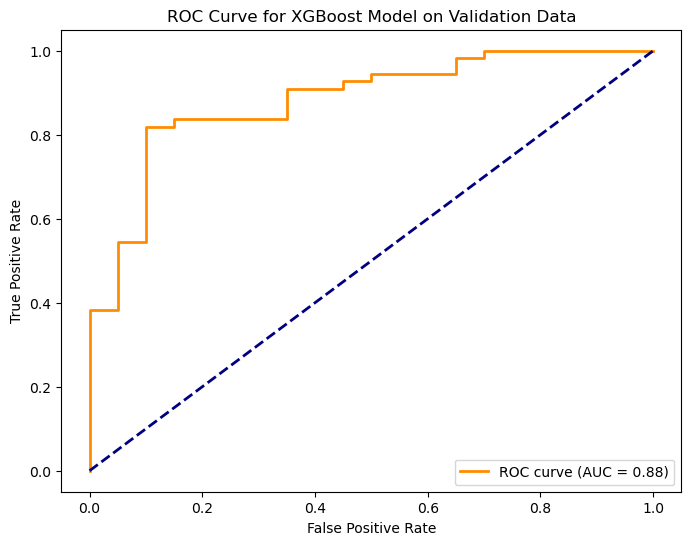

Area Under the Curve (AUC) for XGBoost on Validation Data: 0.8827272727272728
XGBoost Validation Accuracy: 0.8266666666666667
Decision Tree Validation Accuracy: 0.7733333333333333


In [73]:
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
continuous_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)

# One-hot encode categorical features
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_valid_encoded = pd.get_dummies(X_valid, columns=categorical_features, drop_first=True)
data_test_encoded = pd.get_dummies(data_test, columns=categorical_features, drop_first=True)

# Select only the relevant continuous features
X_train_encoded = X_train_encoded[continuous_features]
X_valid_encoded = X_valid_encoded[continuous_features]
data_test_encoded = data_test_encoded[continuous_features]

def train_xgboost_with_l2(features, labels, lambda_values):
    results = {}

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)

    for lam in lambda_values:
        xgb_model = XGBClassifier(reg_lambda=lam, random_state=5)
        auc_scores = cross_val_score(xgb_model, features, y_encoded, scoring="roc_auc", cv=10)
        mean_auc = auc_scores.mean()
        results[lam] = mean_auc

    return results

def plot_roc_curve(fpr, tpr, auc_value):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_value))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for XGBoost Model on Validation Data')
    plt.legend(loc="lower right")
    plt.show()


lambda_values = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

# Step 1: Train XGBoost model and find the optimal lambda
results_dict = train_xgboost_with_l2(X_train_encoded, y_train_encoded, lambda_values)

# Find the optimal lambda
best_lambda = max(results_dict, key=results_dict.get)
print("Optimal Lambda for L2 Regularization:", best_lambda)

# Step 2: Train and test the model with the best parameters
best_xgb_model = XGBClassifier(reg_lambda=best_lambda, random_state=5)
best_xgb_model.fit(X_train_encoded, y_train_encoded)

# Validate the model
y_valid_probs = best_xgb_model.predict_proba(X_valid_encoded)[:, 1]

# Step 3: Plot ROC curve and print AUC for XGBoost model on validation data
fpr, tpr, thresholds = roc_curve(y_valid_encoded, y_valid_probs)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)

print("Area Under the Curve (AUC) for XGBoost on Validation Data:", roc_auc)

# Step 4: Compare with the decision tree model from part A
# Convert probabilities to binary predictions
y_valid_preds = (y_valid_probs > 0.5).astype(int)

# Calculate accuracy
accuracy_xgb = accuracy_score(y_valid_encoded, y_valid_preds)
print(f'XGBoost Validation Accuracy: {accuracy_xgb}')
# Validate the trained model with validation data
y_valid_preds = tree_model.predict(X_valid)

# Calculate and print accuracy
accuracy = accuracy_score(y_valid, y_valid_preds)
print(f'Decision Tree Validation Accuracy: {accuracy}')


# Step 5: Inference on the test data and save the predicted result
y_test_xgb_preds = best_xgb_model.predict(data_test_encoded)
# result_df_xgb = pd.DataFrame({'pred xgboost': y_test_xgb_preds})
# result_df_xgb.to_csv('Ritika_Nigam_preds_xgboost.csv', index=False)


Process of finding the optimal lambda value for l2 regularization:


1. Define Lambda Range: At first we need to specify a range of lambda values to explore, covering a broad spectrum.In this case the range of lambda values are [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
   
2. Train XGBoost Models: Train XGBoost models for each lambda value using cross-validation (cv=10).

3. Evaluate Performance: Use a performance metric (e.g., AUC) to assess model performance during cross-validation.

4. Select Optimal Lambda: Identify the lambda value with the highest average performance across cross-validation folds.

5. Train Model with Optimal Lambda: Train the XGBoost model using the entire training set and the chosen optimal lambda.

6. Validate and Evaluate: Validate the trained model on a separate validation set and assess its performance using the chosen metric.

7. Compare with Other Models: Compare the XGBoost model's performance with other models (e.g., Decision Tree) on the validation set.

8. Inference on Test Data: Apply the trained XGBoost model with the optimal lambda to make predictions on the test data.


On comparing the accuracy score of the XGBoost model and Decision Tree model, I observe that the both models perform well however XGBoost model performs better than the decision tree model built from scratch because of its higher accuracy score as compared to the decision tree model.

In [74]:

# Create a DataFrame with predictions
result_df = pd.DataFrame({'pred_tree': y_test_preds, 'pred_xgboost': y_test_xgb_preds})

# Save the DataFrame to a CSV file
result_df.to_csv('Ritika_Nigam_preds.csv', index=False)
print("Predictions saved to 'Ritika_Nigam_preds.csv'")


Predictions saved to 'Ritika_Nigam_preds.csv'
